<a href="https://colab.research.google.com/github/ztjfreedom/colab/blob/master/keras_lstm_glove_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!pip install numpy==1.16.2

In [94]:
import os
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Bidirectional, BatchNormalization
from keras.layers import LSTM, CuDNNLSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
import h5py

print(np.__version__)

1.16.2


In [0]:
# number of most-frequent words to use
words_num = 10000
# cut texts after this number of words
max_len = 80

In [96]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=words_num)
word_index_dict = imdb.get_word_index()

Loading data...


In [97]:
index_word_dict = dict([(value, key) for (key, value) in word_index_dict.items()])
decoded_review = ' '.join([index_word_dict.get(i - 3, '?') for i in x_train[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [98]:
print('Pad sequences')
x_train = pad_sequences(x_train, maxlen=max_len)  # "0" is used for padding by default
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [99]:
# Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.
print('Data review')
print('x_train[0]:', x_train[0])
print('y_train[0]:', y_train[0])
print('dict:', len(word_index_dict))
print('dict[the]:', word_index_dict['the'])

Data review
x_train[0]: [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32]
y_train[0]: 1
dict: 88584
dict[the]: 1


In [100]:
word_index_dict_modified = {k: v + 3 for k, v in word_index_dict.items()}
print('dict[the]:', word_index_dict_modified['the'])

dict[the]: 4


In [101]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/dataset/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/dataset/'
/content/gdrive/My Drive/Colab Notebooks/dataset


In [102]:
# Parsing GLoVE word embedding files
glove_dict = {}
with open(os.path.join('glove', 'glove.6B.50d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs


print('Found %s word vectors.' % len(glove_dict))

for key in glove_dict.keys():
    print('Frist key:', key)
    break

Found 400000 word vectors.
Frist key: the


In [106]:
# 0 is used for padding, so we set it to all zeros
embedding_matrix = np.random.normal(loc=0.0, scale=1.0, size=(10000, 50))
embedding_matrix[0] = np.zeros(50)
for word, i in word_index_dict_modified.items():
    if i < 10000:
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print('Embedding review:')
print(embedding_matrix.shape)
print(embedding_matrix[0])
print(embedding_matrix[1])

Embedding review:
(10000, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 0.73669772  1.0378199  -1.42765816  0.42543747  0.55742975  0.43900987
 -0.29893897 -0.78122825  1.40404978 -0.81644901  0.04753454  0.4922231
  0.47557672 -0.14526069 -0.92667911  0.46557787 -0.29404902 -0.98781334
  2.38646887  0.29194724 -2.52157981 -1.76983053 -0.15712964  1.18214184
 -0.92001793 -0.39310186  1.47236765  1.14080499 -0.53566164  0.16519076
 -1.42412609  0.35444724  0.59798781 -0.85897838 -0.1504678   0.31609626
  0.4571616  -0.16716747  0.93609336 -0.21170981  1.15178295  2.14846212
  0.87572864  1.13241418 -1.8953211  -0.31710374 -0.29036813  0.40216266
  2.12397337 -0.10892051]


### Freeze all pre-trained embeddings

In [107]:
# model parameters:
embedding_dims = 50
lstm_units = 128

print('Build model...')
model = Sequential()

model.add(Embedding(words_num,
                    embedding_dims,
                    input_length=max_len))

model.add(Dropout(rate=0.5))

# Bidirectional 2 layers LSTM
# CPU ver:
#model.add(LSTM(lstm_units))
# GPU ver:
model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True)))

model.add(BatchNormalization())

model.add(Dropout(rate=0.5))

model.add(Bidirectional(CuDNNLSTM(lstm_units)))

model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
# Freeze the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 80, 50)            500000    
_________________________________________________________________
dropout_23 (Dropout)         (None, 80, 50)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 256)           184320    
_________________________________________________________________
batch_normalization_5 (Batch (None, 80, 256)           1024      
_________________________________________________________________
dropout_24 (Dropout)         (None, 80, 256)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               395264    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257   

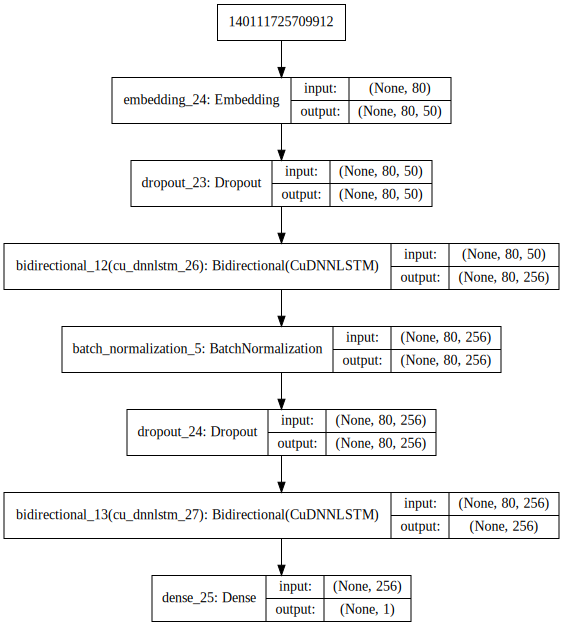

In [108]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [109]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 20s 984us/step - loss: 0.6154 - acc: 0.6605 - val_loss: 0.9811 - val_acc: 0.5198
Epoch 2/20
20000/20000 [==============================] - 16s 786us/step - loss: 0.5670 - acc: 0.7060 - val_loss: 0.6702 - val_acc: 0.6108
Epoch 3/20
20000/20000 [==============================] - 16s 790us/step - loss: 0.5413 - acc: 0.7260 - val_loss: 0.5458 - val_acc: 0.7334
Epoch 4/20
20000/20000 [==============================] - 16s 786us/step - loss: 0.5236 - acc: 0.7385 - val_loss: 0.5640 - val_acc: 0.7026
Epoch 5/20
20000/20000 [==============================] - 16s 786us/step - loss: 0.5111 - acc: 0.7467 - val_loss: 0.4802 - val_acc: 0.7784
Epoch 6/20
20000/20000 [==============================] - 16s 786us/step - loss: 0.5007 - acc: 0.7525 - val_loss: 0.4698 - val_acc: 0.7756
Epoch 7/20
20000/20000 [==============================] - 16s 783us/step - loss: 0.4916 - acc: 0.7576 - val_loss: 0.5

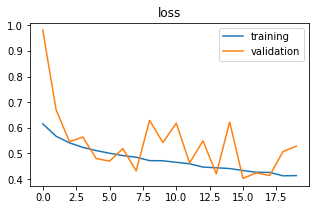

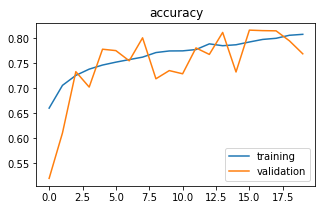

In [111]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

In [112]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 76.65%


### Do not freeze pre-trained embeddings

In [118]:
# model parameters:
embedding_dims = 50
lstm_units = 128

print('Build model...')
model = Sequential()

model.add(Embedding(words_num,
                      embedding_dims,
                      input_length=max_len))

model.add(Dropout(rate=0.7))

# Bidirectional 2 layers LSTM
# CPU ver:
#model.add(LSTM(lstm_units))
# GPU ver:
model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True)))

model.add(BatchNormalization())

model.add(Dropout(rate=0.7))

model.add(Bidirectional(CuDNNLSTM(lstm_units)))

model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
# Only free the embedding of pad token
model.layers[0].set_weights([embedding_matrix])

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
print(model.summary())

W0627 09:46:29.535029 140115035862912 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Build model...


W0627 09:46:30.003671 140115035862912 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 80, 50)            500000    
_________________________________________________________________
dropout_33 (Dropout)         (None, 80, 50)            0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 80, 256)           184320    
_________________________________________________________________
batch_normalization_9 (Batch (None, 80, 256)           1024      
_________________________________________________________________
dropout_34 (Dropout)         (None, 80, 256)           0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 256)               395264    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total para

In [119]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 21s 1ms/step - loss: 0.5340 - acc: 0.7177 - val_loss: 1.5396 - val_acc: 0.5344
Epoch 2/20
20000/20000 [==============================] - 16s 805us/step - loss: 0.3556 - acc: 0.8468 - val_loss: 0.3653 - val_acc: 0.8388
Epoch 3/20
20000/20000 [==============================] - 16s 806us/step - loss: 0.3085 - acc: 0.8694 - val_loss: 0.4002 - val_acc: 0.8190
Epoch 4/20
20000/20000 [==============================] - 16s 803us/step - loss: 0.2678 - acc: 0.8924 - val_loss: 0.3985 - val_acc: 0.8344
Epoch 5/20
20000/20000 [==============================] - 16s 805us/step - loss: 0.2333 - acc: 0.9058 - val_loss: 0.4064 - val_acc: 0.8344
Epoch 6/20
20000/20000 [==============================] - 16s 805us/step - loss: 0.2127 - acc: 0.9165 - val_loss: 0.4001 - val_acc: 0.8328
Epoch 7/20
20000/20000 [==============================] - 16s 794us/step - loss: 0.1902 - acc: 0.9254 - val_loss: 0.425

In [121]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 80.67%
